# Basic settings

### Settings that define the different runs

Each cell contains one run settings. These should all be coded as "Raw NBConvert" cells. The wrapper function will pull out the appropriate settings and run the full notebook, and finally save the output as a separate Jupyter notebook.

In [1]:
runname = "Mags"

PPRpredsuse = ['rband Mag','gband Mag','iband Mag','zband Mag']
NNpredsuse = PPRpredsuse

predsscl = ['rband Mag','gband Mag','iband Mag','zband Mag']

In [2]:
file_dir='./temp/ChadAnalyses/'+runname+'/'

This is the end of settings cells.

In [3]:
%%capture ReportOutput

print("\n----------------------------------------------------")
print("Output files stored in:")
print(file_dir)
print("\n----------------------------------------------------")
print("Predictors Used in Projection Pursuit Model:")
print(PPRpredsuse)
print("\n----------------------------------------------------")
print("Predictors Used in Neural Network Model:")
print(NNpredsuse)

### Settings that are fixed across runs

In [4]:
# This controls the number of projection functions in the PPR
ruse = 5

traintestseed = 1

epochs=500

learning_rate = 0.001

decay_rate = learning_rate / epochs

momentum = 0.8


These are the "quick" settings. They are designed to allow the user to more rapidly verify that there are not bugs in the setup.

In [5]:
%%capture ReportOutput

ReportOutput()

print("\n----------------------------------------------------")
print("Number of projection functions in PPR:",ruse)
print("\n----------------------------------------------------")
print("Seed used in train/test split:",traintestseed)

# Import Packages

In [6]:
%pylab inline

import illustris_python as il
import pandas as pd
import pickle

import os

from astropy.table import Table

from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


In [7]:
basePath= '/hildafs/datasets/IllustrisTNG/TNG100-1/output'
snapNum=99 #refers to final snapshot, redshift of zero

# Create the combined catalog

Start with data from the base Illustris catalog.

See https://www.tng-project.org/data/docs/specifications/#sec2b

These are the fields that will be extracted from this catalog.

In [8]:
addvariables = ['SubhaloBHMass','SubhaloGasMetallicity','SubhaloSFR',
                'SubhaloStarMetallicity','SubhaloVmax']

In [9]:
fields = ['SubhaloGrNr',
          'SubhaloFlag',
          'SubhaloMassType',
          'SubhaloPos',
          'SubhaloStellarPhotometrics',
          'SubhaloMassInHalfRad',
          'SubhaloHalfmassRad',
          'SubhaloHalfmassRadType'] + addvariables

In [10]:
subhalos=il.groupcat.loadSubhalos(basePath,snapNum,fields=fields)

This is here just for reference:

0. PartType0 - GAS
1. PartType1 - DM
2. PartType2 - (unused)
3. PartType3 - TRACERS
4. PartType4 - STARS & WIND PARTICLES
5. PartType5 - BLACK HOLES

### Read in additional catalogs

THIS SEEMS TO BE UNNECESSARY. EVERYTHING IN HERE APPEARS TO BE IN THE FULL CATALOG BELOW.
The shape catalog. Note that this catalog already comes in with a mass cut of `10**10 M_sun`.

In [11]:
#df_non_red_100_subfind_shapes = pd.DataFrame(
#    pickle.load(open('/hildafs/datasets/IllustrisTNG/TNG100-1/df_non_red_100_subfind_mass-cut10', "rb" ) ))
#df_non_red_100_subfind_shapes.shape

The velocity dispersion catalog.

In [12]:
df_non_red_100_subfind_sigma_v = pd.DataFrame(pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_vel_disp_100.0.p', 
         "rb" ) ))

print(df_non_red_100_subfind_sigma_v.shape)
df_non_red_100_subfind_sigma_v.head()

(20051, 5)


,gal_id,Lx,Ly,Lz,sigma_v
0,0.0,-9.085662,-7.872045,-4.559502,374.378662
1,1.0,1.795185,-0.857926,1.563985,214.005508
2,2.0,0.620052,2.585010,0.742175,196.719849
3,3.0,0.292968,-0.387597,-1.368885,106.750359
4,4.0,-0.058817,0.112009,-0.858557,116.125282


The "full" catalog.

In [13]:
df_non_red_100_subfind_full = pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_component_shapes_3I_subfind_FULL_mass-cut9.p', 
         "rb" ) )

print(df_non_red_100_subfind_full.shape)
df_non_red_100_subfind_full.head()

(20051, 114)


,gal_id,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,...,bv_z,cv_x,cv_y,cv_z,mass,gal_pos_x,gal_pos_y,gal_pos_z,e1,e2
0,0.0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,...,0.377225,0.782535,0.612006,0.114402,3.705585e+12,0.849091,26.326996,18.306934,-0.109703,-0.157248
1,1.0,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,...,0.469768,-0.159400,0.476258,-0.864737,5.587917e+11,0.106473,24.633322,16.900553,0.295580,0.009956
2,2.0,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,...,-0.293690,0.135702,0.904910,0.403390,6.271396e+11,0.853112,26.725748,17.510679,0.026402,-0.016790
3,3.0,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,...,-0.012360,-0.111798,0.556926,0.823003,1.715515e+11,0.245455,26.517372,15.888749,-0.066341,-0.033003
4,4.0,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,...,0.015853,-0.002944,-0.163988,0.986458,1.333404e+11,0.768784,26.518290,15.530523,-0.028562,0.007162


Note that, for some reason, `gal_id` appears twice in the "full" catalog. Hence, the `drop` function removes both of those instances. It's for this reason that I am dropping from the "full" catalog, and not from the velocity dispersion catalog.

In [14]:
fullinfo = pd.concat(
    [df_non_red_100_subfind_full.drop({'gal_id'},axis=1),
     df_non_red_100_subfind_sigma_v], 
     axis=1)

### Create the merged catalog

For each variable in the base catalog, need to extract the elements based on `gal_id` in the supplemental catalog.

The photometric magnitudes.

In [15]:
fullinfo['gband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),4]
fullinfo['rband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),5]
fullinfo['iband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),6]
fullinfo['zband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),7]

Colors

In [16]:
fullinfo['g - r'] = fullinfo['gband Mag'] - fullinfo['rband Mag']
fullinfo['r - i'] = fullinfo['rband Mag'] - fullinfo['iband Mag']
fullinfo['i - z'] = fullinfo['iband Mag'] - fullinfo['zband Mag']

Size and mass. (Mass measures stars.)

In [17]:
fullinfo['size'] = subhalos['SubhaloHalfmassRad'][fullinfo['gal_id'].astype('int')]
fullinfo['galaxy_mass'] = \
     subhalos['SubhaloMassType'][fullinfo['gal_id'].astype('int'),4]*10**10

Other variables from the base catalog.

In [18]:
for addvar in addvariables:
    fullinfo[addvar] = subhalos[addvar][fullinfo['gal_id'].astype('int')]

The subhalo flag is mapped over, in order to exclude flagged observations.

In [19]:
fullinfo['subhaloflag'] = subhalos['SubhaloFlag'][fullinfo['gal_id'].astype('int')]

There are some duplicated columns. Note that the data in them were not actually identical. In particular, the position variables were off by a factor of 1000.

In [20]:
fullinfo = fullinfo.loc[:,~fullinfo.columns.duplicated()]

Exclude any observations for which the `SubhaloFlag` is `False` or the mass is not sufficiently large. If mass cutoff is $10^9$, there should be 17513 rows remaining. If the mass cutoff is $10^{10}$, there should be 4987 rows remaining.

In [21]:
keep = (fullinfo['subhaloflag']) & (fullinfo['galaxy_mass'] > 10**9) 
print(sum(keep))

subinfo = fullinfo[keep].copy()

17513


Create log-transformed versions of some variables.

In [22]:
varsToLogTransform = ['galaxy_mass',
                      'sigma_v',
                      'size']

for varname in varsToLogTransform:
    subinfo['log ' + varname] = log10(subinfo[varname])

Some of the variables have a spike of values at zero, but are otherwise positive (and skewed). The strategy taken here is to create an indicator variable for zero values, and then log transform the positive values. Hence, there are two variables included in the model for each of these.

In [23]:
# SubhaloBHMassZero

subinfo['SubhaloBHMassZero'] = (subinfo['SubhaloBHMass'] == 0).astype(int)

subinfo['log SubhaloBHMass'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloBHMass']]


# SubhaloSFR

subinfo['SubhaloSFRZero'] = (subinfo['SubhaloSFR'] == 0).astype(int)

subinfo['log SubhaloSFR'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloSFR']]


# SubhaloGasMetallicity is not skewed

subinfo['SubhaloGasMetallicityZero'] = (subinfo['SubhaloGasMetallicity'] == 0).astype(int)


Create indicators for the different size bins.

In [24]:
holdQ = pd.qcut(subinfo['log size'],4,labels=["SizeQ1","SizeQ2","SizeQ3","SizeQ4"])

subinfo['SizeQ1'] = (holdQ == "SizeQ1").astype(int)
subinfo['SizeQ2'] = (holdQ == "SizeQ2").astype(int)
subinfo['SizeQ3'] = (holdQ == "SizeQ3").astype(int)
subinfo['SizeQ4'] = (holdQ == "SizeQ4").astype(int)

subinfo['small sigma_v'] = (subinfo['log sigma_v'] <-2).astype(int)

#subinfo = subinfo[subinfo['SizeQ4']==1]

## Set the predictors and response

In [25]:
respuse = 'log size'

The predictors are now set at the top of the file.

## Scale Selected Predictors

In [26]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(copy=True)

scaler.fit(subinfo[predsscl])

foo = pd.DataFrame(scaler.transform(subinfo[predsscl]),columns=predsscl, index=subinfo.index)

subinfo = pd.DataFrame.join(subinfo.drop(predsscl,axis=1),foo)

In [27]:
subinfo.head()

,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,a_simple_disk,...,SubhaloGasMetallicityZero,SizeQ1,SizeQ2,SizeQ3,SizeQ4,small sigma_v,rband Mag,gband Mag,iband Mag,zband Mag
0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,0.263015,...,0,0,0,0,1,0,-4.764354,-4.514183,-4.818780,-4.828142
1,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,0.093535,...,0,0,0,0,1,0,-3.128438,-2.902219,-3.187275,-3.206353
2,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,0.038423,...,0,0,0,0,1,0,-3.439029,-3.341743,-3.455535,-3.455128
3,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,0.017284,...,0,0,0,0,1,0,-2.542429,-2.474658,-2.551160,-2.547872
4,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,0.018827,...,0,0,0,0,1,0,-1.926942,-1.784699,-1.969079,-1.985330


## Split into Test and Training Sets

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_features, test_features, train_labels, test_labels = \
   train_test_split(subinfo[PPRpredsuse], subinfo[respuse], 
        test_size = 0.2, random_state = traintestseed)

train_features = train_features.astype(float)
test_features = test_features.astype(float)

# Projection Pursuit Regression

In [30]:
#pip install projection-pursuit
from skpp import ProjectionPursuitRegressor

In [31]:
deguse = 5

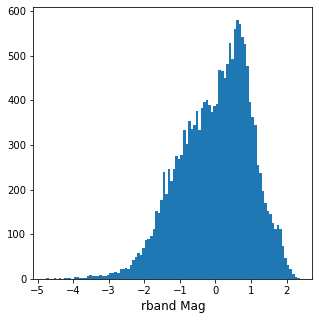

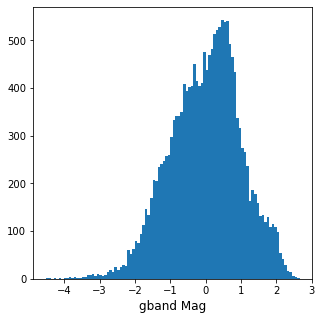

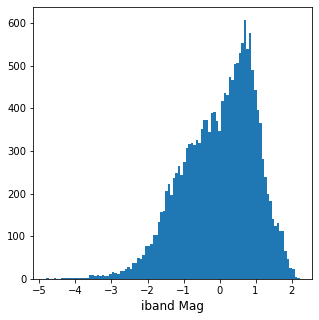

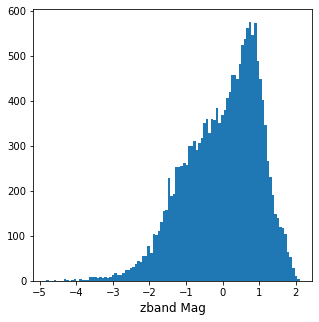

In [32]:
for pred in PPRpredsuse:
    plt.figure(figsize=[5,5])
    hist(subinfo[pred], bins=100)
    plt.xlabel(pred,size=12)
    plt.show()

Fit the model

In [33]:
#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler(copy=True)

#scaler.fit(train_features)

#train_features_scl = pd.DataFrame(scaler.transform(train_features),columns=predsuse)

#test_features_scl = pd.DataFrame(scaler.transform(test_features),columns=predsuse)

In [34]:
PPRestimatorsplit = ProjectionPursuitRegressor(r=ruse,
        show_plots=False, degree=deguse, fit_type='spline')

PPRestimatorsplit.fit(train_features,train_labels)

ProjectionPursuitRegressor(degree=5, fit_type='spline', r=5)

This is the projection of the data using the alpha vectors, i.e., this is prior to the application of the nonlinear functions.

In [35]:
projs = PPRestimatorsplit.transform(train_features)

Determine the fits from each projection.

In [36]:
fitsbyproj = projs.copy()
for i in range(ruse):
    fitsbyproj[:,i] = PPRestimatorsplit._f[i](projs[:,i])*PPRestimatorsplit._beta[0][i]

Calculate the fitted values and residuals, but also compare with what's returned by `predict`, as a double check.

In [37]:
fittedvalues = fitsbyproj.sum(1)
residuals = train_labels - fittedvalues

print(fittedvalues)
print(PPRestimatorsplit.predict(train_features))

[1.43163163 1.67800101 1.33416996 ... 0.42302371 1.40704243 0.02878348]
[1.43163163 1.67800101 1.33416996 ... 0.42302371 1.40704243 0.02878348]


This illustrates how each nonlinear function is fit to the residuals of the other fits.

In [38]:
%%capture ReportOutput

ReportOutput()

for i in range(ruse):
    
    # The residuals from the fit leaving out projection i
    residswithouti = residuals + fitsbyproj[:,i]
    
    fig,axs = plt.subplots(1,2,figsize=[12,4])
    
    axs[0].barh(PPRpredsuse, PPRestimatorsplit._alpha[:,i])
    axs[0].plot([0, 0], [-5, len(PPRpredsuse)+5], 'k-')
    axs[0].set(ylim=(-1,len(PPRpredsuse)))
    
    axs[1].hist2d(x=projs[:,i],
       y=residswithouti,
         bins=300,
         norm=matplotlib.colors.LogNorm())

    foo = PPRestimatorsplit._f[i](sort(projs[:,i]))*PPRestimatorsplit._beta[0][i]

    plot(sort(projs[:,i]),foo,color="r")
    plt.title('')
    plt.ylabel('Residuals',size=12)
    plt.xlabel(('Projection '+str(i+1)),size=12)
    plt.show()

Plot of residuals versus fitted values.

In [39]:
%%capture ReportOutput

ReportOutput()

plt.figure(figsize=[5,5])
hist2d(x=fittedvalues,
       y=residuals,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('')
plt.ylabel('Residuals',size=12)
plt.xlabel('Fitted Values',size=12)
plt.show()

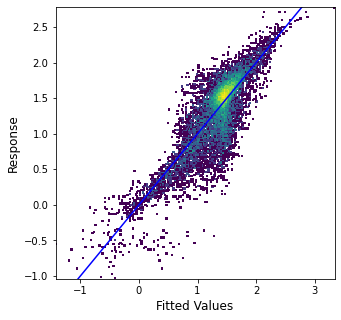

In [40]:
plt.figure(figsize=[5,5])
hist2d(x=fittedvalues,
       y=train_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('')
plt.ylabel('Response',size=12)
plt.xlabel('Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')

plt.show()

### Performance on test set

In [41]:
PPRfitsontest = PPRestimatorsplit.predict(test_features)

In [42]:
%%capture ReportOutput

ReportOutput()

plt.figure(figsize=[5,5])
hist2d(x=PPRfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Projection Pursuit Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

RMSE

In [43]:
%%capture ReportOutput

ReportOutput()

print("\n----------------------------------------------------")

print("RMSE PPR on test set:",round(sqrt(mean((PPRfitsontest-test_labels)**2)),3))

print("RMSE PPR on training set:",round(sqrt(mean(residuals**2)),3))

Refit the model using the full data set. Calculate and store the residuals.

In [44]:
PPRestimatorfull = ProjectionPursuitRegressor(r=ruse,show_plots=False,
            degree=deguse, fit_type='spline')

PPRestimatorfull.fit(subinfo[PPRpredsuse].astype(float),subinfo[respuse])

ProjectionPursuitRegressor(degree=5, fit_type='spline', r=5)

In [45]:
subinfo['PPRresids'] = subinfo[respuse] - PPRestimatorfull.predict(subinfo[PPRpredsuse].astype(float))

print(mean(subinfo['PPRresids']))
print(std(subinfo['PPRresids']))

-2.651986072285952e-06
0.26339868952751433


This will create columns in the main data frame which equal the nonparametric function applied to the projection. This is done for both the fits from the full data set, and from the fits from the training/test split.

In [46]:
projsfull = PPRestimatorfull.transform(subinfo[PPRpredsuse])

for i in range(ruse):
    subinfo['PPRcompfull' + chr(i+ord('0'))] = \
       PPRestimatorfull._f[i](projsfull[:,i].astype(float))*PPRestimatorfull._beta[0][i]
    
    
projssplit = PPRestimatorsplit.transform(subinfo[PPRpredsuse])

for i in range(ruse):
    subinfo['PPRcompsplit' + chr(i+ord('0'))] = \
       PPRestimatorsplit._f[i](projssplit[:,i].astype(float))*PPRestimatorsplit._beta[0][i]

In [47]:
subinfo.head()

,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,a_simple_disk,...,PPRcompfull0,PPRcompfull1,PPRcompfull2,PPRcompfull3,PPRcompfull4,PPRcompsplit0,PPRcompsplit1,PPRcompsplit2,PPRcompsplit3,PPRcompsplit4
0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,0.263015,...,-27.604632,-4.979577,36.512120,-0.024708,-0.216315,1.641552,-0.719920,2.604135,-0.104936,-0.079913
1,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,0.093535,...,0.641340,-0.907997,2.538823,0.043684,-0.056110,1.579933,0.414269,0.319868,0.054208,0.009753
2,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,0.038423,...,1.707466,-0.261275,1.034898,-0.081565,-0.152549,1.583379,0.225877,0.253601,-0.023083,0.029036
3,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,0.017284,...,2.348417,-0.284053,0.003618,-0.018709,-0.071552,1.579319,0.088399,0.233323,0.042510,-0.003231
4,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,0.018827,...,2.246750,-0.261537,0.014123,0.057616,-0.012196,1.567529,0.231959,0.225536,0.068624,-0.014396


## Random Forest

Some of the syntax is taken from 
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

Instantiate model with `numtrees` decision trees

Train the model on training data

Predict on the test set

Fit on the full data set.

## Tuning parameter selection for Random forest

Some of this code is adapated (stolen) from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


# Neural Network

Some of this syntax is based on https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

Need to redo the training/test split (using the same seed), so that the new variables are correctly allocated.

In [48]:
train_features, test_features, train_labels, test_labels = \
   train_test_split(subinfo[NNpredsuse], subinfo[respuse], 
        test_size = 0.2, random_state = traintestseed)

train_features = train_features.astype(float)
test_features = test_features.astype(float)

In [49]:
from tensorflow.keras import models, layers, utils, backend as K

Set up the model architecture

In [50]:
n_features = len(NNpredsuse)

model = models.Sequential(name="SimpleNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop2", rate=0.2),
    
    ### hidden layer 3
#    layers.Dense(name="h3", units=20, 
 #                activation='relu'),
  #  layers.Dropout(name="drop3", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='linear')
])
model.summary()

Model: "SimpleNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   (None, 200)               1000      
_________________________________________________________________
drop1 (Dropout)              (None, 200)               0         
_________________________________________________________________
h2 (Dense)                   (None, 200)               40200     
_________________________________________________________________
drop2 (Dropout)              (None, 200)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 201       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
_________________________________________________________________


In [51]:
%%capture ReportOutput

ReportOutput()

print("\n----------------------------------------------------")
model.summary()

Define metrics

In [52]:
def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

Compile the neural network

In [53]:
from tensorflow.keras.optimizers import SGD


sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model.compile(optimizer=sgd, loss='mean_squared_error', metrics=[R2])

In [54]:
%%capture ReportOutput

ReportOutput()

print("\n----------------------------------------------------")
print("Number of epochs:",epochs)
print("learning rate:",learning_rate)
print("decay rate:",decay_rate)
print("momentum:",momentum)



In [55]:
training = model.fit(x=train_features, y=train_labels, 
     batch_size=32, epochs=epochs, shuffle=True, verbose=0,
    validation_split=0.3)

In [56]:
NNfitsontest = np.reshape(model.predict(test_features),-1)
NNfitsontrain = np.reshape(model.predict(train_features),-1)

print(sqrt(mean((NNfitsontest-test_labels)**2)))

print(sqrt(mean((NNfitsontrain-train_labels)**2)))

0.3120203867679842
0.3047150208197385


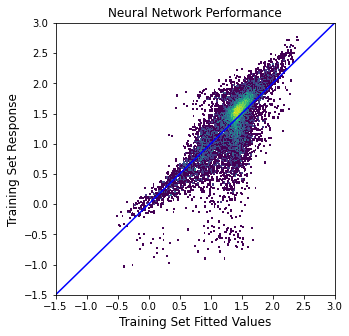

In [57]:
plt.figure(figsize=[5,5])
hist2d(x=NNfitsontrain,
       y=train_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Neural Network Performance')
plt.ylabel('Training Set Response',size=12)
plt.xlabel('Training Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

In [58]:
%%capture ReportOutput

ReportOutput()

plt.figure(figsize=[5,5])
hist2d(x=NNfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Neural Network Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

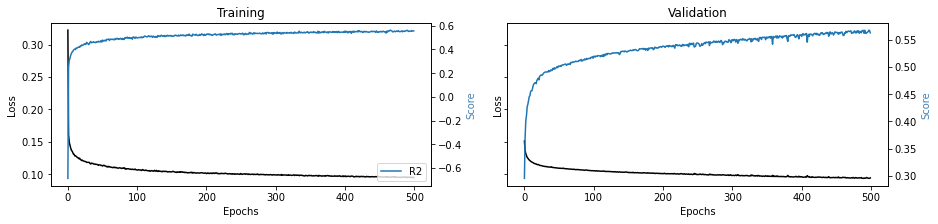

In [59]:
# plot

metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training

ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric) 
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation

ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

In [60]:
%%capture ReportOutput

ReportOutput()

print("\n----------------------------------------------------")

print("RMSE NN on test set:",round(sqrt(mean((NNfitsontest-test_labels)**2)),3))

print("RMSE NN on training set:",round(sqrt(mean((NNfitsontrain-train_labels)**2)),3))

### Refit NN to entire data set

In [61]:
NNfullmodel = model

NNfullmodel.compile(optimizer=sgd, loss='mean_squared_error', metrics=[R2])

holdpreds = subinfo[NNpredsuse].astype(float)
trainingfull = NNfullmodel.fit(x=holdpreds, y=subinfo[respuse], 
     batch_size=32, epochs=epochs, shuffle=True, verbose=0,
    validation_split=0.3)
    
NNfullfits = np.reshape(NNfullmodel.predict(holdpreds),-1)
subinfo['NNfullresids'] = subinfo[respuse]-NNfullfits

# Set up Correlation Function Estimation

For testing purposes, add a column which is the residual in the response, if the model were simply the average response.

In [62]:
subinfo['SimpResids'] = subinfo[respuse] - subinfo[respuse].mean()

Define the column that will be used for the cross correlation quantity, e.g. size, mass, etc. 

In [63]:
S_weight_column='NNfullresids'

Set up file and directory for output.

In [64]:

file_name='kappa_'+S_weight_column  #prefix to be appended to the files being saved. Should be different for different datasets.

os.makedirs(file_dir,exist_ok=True)

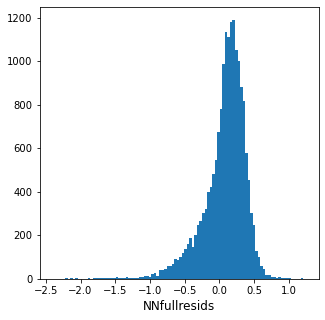

In [65]:
plt.figure(figsize=[5,5])
hist(subinfo[S_weight_column], bins=100)
plt.xlabel(S_weight_column,size=12)
plt.show()    

In [66]:
""" this function generates the input file for corr_pc
 corr_pc takes two samples to compute cross correlations. 
 Shape sample: Sample of galaxies with shapes. For density correlations it is not necessary to pass shapes. 
               Prefix of filenames for this sample should be passed vias file_nameS
 Density sample: Sample of galaxies/particles that trace density field. For density correlations it is not necessary to pass shapes. 
                 If shapes are passed for this sample, w++ can be computed. Prefix of filenames for this sample should be passed vias file_nameD.
                 If auto correlation is to be computed, simply set file_nameD=file_nameS.
 file_name: This is the prefix corr_pc will use to save the output files containing two point correlations. Input file to be passed to corr_pc is 
            also saved with this name. input file is saved in file_dir and the outputs are saved in new directory, file_dir+corr_data_out.
 corr: two point correlation to be computed. This should be density-density (wgg,wmm), shape-density (wg+) or shape-shape(w++). 
        When computing wg+, corr_pc will also compute and save wgg by default since pair counting is done anyways. 
        When doing w++, wg+ and wgg are also computed and saved.
 n_shape, n_density: number of galaxies in the shape sample and density sample respectively.
 do_jk: Whether to do jackknifing or not.
 njk: number of jackknife regions. jackknife regions are assumed to be labelled from 0...njk-1.
"""
def inp_gen(file_dir,file_name,file_nameS,file_nameD,corr=3,n_shape=0,n_density=0,njk=100,do_jk=1):
    s=""
    s=s+"which_corr     "+str(corr)+"\n" #0: density-density, 1: ia: shape-density, 2 ia:shape-shape, 3:kappa-density
    s=s+"coordinates    6"+"\n"  #0: rp-pi
    s=s+"estimator      0"+"\n"  #0:landy-szalay (LS): cross. works for both auto and cross correlations. For auto, pass same filenames for shape and density samples 
                                 # 1: LS:auto, for auto correlation only
    s=s+"data_sorted     0"+"\n"  #0: no sorting, 1:sorted by z, 2:sorted by dec (y)
    s=s+"use_comoving    1"+"\n"
    s=s+"do_jk           "+str(do_jk)+"\n" #0: no jackknife, 1: do jackknife. jk regions must be passed in a file. are assumed to be from 0..njk-1
    s=s+"sig_crit        0"+"\n" #for weak lensing, not important for ia, gg corrs.

    #following passes information about shape sample
    s=s+"shape_pos       "+file_dir+file_nameS+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"shape_z         "+file_dir+file_nameS+'_z.dat'+"\n"    # z coordinate
    s=s+"shape_e         "+file_dir+file_nameS+'_kappa.dat'+"\n"    # e1, e2 or kappa
#     s=s+"shape_wt         "+file_dir+file_nameS+'_wt.dat'+"\n"  # weights on galaxies. If no weighting, pass 0
    s=s+"shape_wt         0"+"\n"
    s=s+"shape_jk        "+file_dir+file_nameS+'_jk.dat'+"\n"   # jackknife regions

    # following passes information about density sample
    s=s+"density_patch   0"+"\n" #for weak lensing, not important for ia, gg corrs.
    s=s+"density_pos     "+file_dir+file_nameD+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"density_z       "+file_dir+file_nameD+'_z.dat'+"\n"    # z coordinate
    s=s+"density_wt       0"+"\n"  # weights on galaxies/particles. If no weighting, pass 0
#     s=s+"density_wt       "+file_dir+file_nameD+'_wt.dat'+"\n"  # weights on galaxies/particles. If no weighting, pass 0
    s=s+"density_jk      "+file_dir+file_nameD+'_jk.dat'+"\n"   # jackknife regions    
    s=s+"density_e      0"+"\n"   #if doing shape-shape, this file should be passed. # e1, e2

    # following passes information about randoms corresponding to shape sample
    s=s+"Srandom_pos      0"+"\n"
    s=s+"Srandom_z        0"+"\n"
    s=s+"Srandoms_wt      0"+"\n"
    s=s+"Srand_jk         0"+"\n"

    # following passes information about randoms corresponding to density sample
    s=s+"Drandom_patch    0"+"\n"
    s=s+"Drandom_pos      0"+"\n"
    s=s+"Drandom_z        0"+"\n"
    s=s+"Drandoms_wt      0"+"\n"
    s=s+"drand_jk         0"+"\n"

    s=s+"distances        0"+"\n"  #not needed for PB
    s=s+"patch_file       0"+"\n"  #not needed for PB
    s=s+"out_file         "+file_dir+"corr_data_out/"+file_name+"_"+"\n"  # prefix for the output files.
    
    os.makedirs(file_dir+"corr_data_out/",exist_ok=True) #directory where outputs are saved.
    
    s=s+"n_threads       0"+"\n"   # number of openmp threads to use. 0== use maximum available.
    s=s+"n_shape         "+str(n_shape)+"\n"  #number of galaxies in shape sample
    s=s+"n_density       "+str(n_density)+"\n"  #number of galaxies in density sample
    s=s+"n_Srand         0"+"\n"
    s=s+"n_Drand         0"+"\n"
    s=s+"rand_subsample  0"+"\n"  #subsample randoms to speed up calculations.
    s=s+"n_jk          "+str(njk)+"\n"  #number of jk regions. regions are assumed to be labelled from 0....njk-1
    s=s+"n_patch         0 "+"\n"#not needed for PB

    s=s+"binR_min        0.1"+"\n"  # rp_min for the bins
    s=s+"binR_max       20"+"\n" # rp_max for the bins
    s=s+"n_bins         10"+"\n" #number of rp bins to use
    s=s+"lin_bin         0"+"\n"  #linear or log bins. 0: log, 1:linear
    s=s+"n_p_bin         20"+"\n"  #number of pi bins to use
    s=s+"pmin         -22"+"\n"  # pi_min (line of sight or z separation)
    s=s+"pmax         22"+"\n"   # pi_max (line of sight or z separation)
    s=s+"z_min         0"+"\n"    
    s=s+"z_max         300"+"\n" 
    s=s+"dz            0.0001"+"\n" #not needed for PB
    s=s+"z_sep_min     -100"+"\n"  
    s=s+"z_sep_max     100"+"\n"   
    s=s+"periodic_box  1"+"\n"
    s=s+"box_size     75"+"\n"  #size of the box.

    fil=open(file_dir+file_name+'.inp','w')
    fil.write(s)


This function splits the sim box into a grid in x-y plane. Number of grid splits along each axis are given by njk1, for a total of njk1^2 sub-sample regions.
After this, each point in data (galaxy or particle) is assigned to its sub-sample.

In [67]:
def jk_box(data=[],Lbox=None,njk1=7):
    if Lbox is None:
        Lbox=np.ceil(max(data['x']))
        print('jk_box using Lbox=',Lbox)
    xjk=np.linspace(0,Lbox,njk1+1)
    yjk=np.linspace(0,Lbox,njk1+1)
    jk=np.zeros(len(data))
    jjk=0
    for i in np.arange(njk1):
        xil=xjk[i]
        xih=xjk[i+1]
        x1=data['x']>xil
        x2=data['x']<xih
        for j in np.arange(njk1):
            yil=yjk[j]
            yih=yjk[j+1]
            y1=data['y']>yil
            y2=data['y']<=yih
            jk[x1*x2*y1*y2]=jjk
            jjk+=1
#     jk=np.array(jk,dtype=[('jk','int32')])
    return jk

In [68]:
S_dat = Table.from_pandas(subinfo)

Define `x`,`y`,`z` columns for cordinates. We will use the names `x`,`y`,`z`, below, instead of `gal_pos_x` etc. Different versions of the catalog have different naming conventions, please check. We will also use units of Mpc instead of Kpc, hence division by 1000.

In [69]:
S_dat['x']=np.float64(S_dat['gal_pos_x']/1000)
S_dat['y']=np.float64(S_dat['gal_pos_y']/1000)
S_dat['z']=np.float64(S_dat['gal_pos_z']/1000)

Get jackknife regions for all the galaxies.

In [70]:
S_dat['jk'] = jk_box(data=S_dat)
S_dat.sort('z')

jk_box using Lbox= 75.0


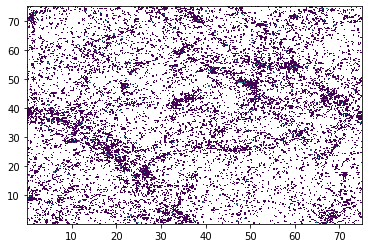

In [71]:
_=hist2d(S_dat['y'],S_dat['z'],1000,norm=LogNorm())

We will assume density and shape sample to be same, hence following can be done.

For density sample, still use entire sample, but for `S_dat` restrict to satellite or central.

In [72]:
D_dat=S_dat

We define a new column kappa, which will contain the "processed" version of weight column defined above. The "processed" here could be mean subtraction, renormalization or taking log of the quantity.
Remeber to do this on the final version of catalog, after all the cuts have been applied since that can affect the mean, etc.
 For mass, we will take log to prevent few massive galaxies from dominating the measurements.

In [73]:
#S_dat['kappa']=np.log10(S_dat[S_weight_column])

S_dat['kappa'] = S_dat[S_weight_column]
S_dat['kappa'] -= S_dat['kappa'].mean()

Function to write data files in format that can be read by corr_pc

In [74]:
def write_data(data,file_name,file_dir,wt_col=None):
    file_name=file_dir+file_name
    np.savetxt(file_name+'_pos.dat',np.column_stack((data['x'],data['y']))) #x,y position of galaxies
    np.savetxt(file_name+'_z.dat',data['z']) # z position of galaxies
    if 'jk' in data.columns:
        np.savetxt(file_name+'_jk.dat',data['jk'],fmt='%i') #jackknife is read as integer
    if 'kappa' in data.columns: #ellipticities. corr_pc takes e1, e2
        np.savetxt(file_name+'_kappa.dat',data['kappa'])
    if wt_col is not None: #wt to be applied to each galaxy/particle.
        wt=data[wt_col]*1.
        wt/=wt.mean()
        np.savetxt(file_name+'_wt.dat',wt)

Write shape data to files.

In [75]:
file_nameS=file_name+'_shape'
write_data(data=S_dat,file_name=file_nameS,file_dir=file_dir,)#wt_col='mass')

Write density data to files. Only necessary if the two catalogs are different.

In [76]:
#file_nameD=file_name+'_density'
#write_data(data=D_dat,file_name=file_nameD,file_dir=file_dir,wt_col='mass')
file_nameD=file_nameS

Generate the input file. Corr_pac will be called using this file.
`corr=0` will only do wgg like correlation, no shapes. set `corr=1` for wg+ and wgg

In [77]:
inp_gen(file_dir=file_dir,file_name=file_name,file_nameS=file_nameS,file_nameD=file_nameD,corr=3,n_shape=len(S_dat),n_density=len(D_dat),
        njk=int(S_dat['jk'].max()+1),do_jk=1) 

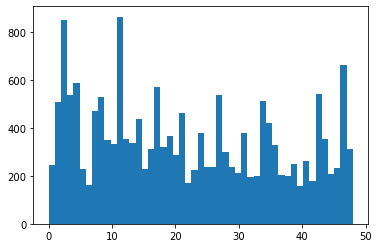

In [78]:
_=hist(S_dat['jk'],int(S_dat['jk'].max()+1))

From within corr_pc directory, you can run corr_pc as 

`./corr_pc file_dir/file_name.inp`

For example:

`./corr_pc ./temp/ill_test/ill_test_kappa.inp`

`./corr_pc ./temp/ChadAnalyses/kappa_SimpResids.inp`

In [79]:
foo = './corr_pc '+ file_dir + file_name+'.inp'
print('Running '+foo)
holdout = os.system(foo)
if(holdout == 0):
    print("Success")
else:
    print("Failure")

Running ./corr_pc ./temp/ChadAnalyses/Mags/kappa_NNfullresids.inp


Success


## Process the results to create correlation plots

In [80]:
def check_empty(arr): # True is empty
    try:
        #print not arr.any()
        try:
            return not arr.any()
        except:
            if arr.size!=0: #for rec array
                return False
            else:
                return True
    except:
        #print not bool(arr)
        return not bool(arr) #for other python types, including dictionary

In [81]:
ignore_keys=['rp','r','jk','cov','corr','jk_err','jkerr','data','data0']
class cov_corr():
    def mean_calc(self,data=[],axis=1):
        return np.mean(data,axis)

    def var_calc(self,data=[],axis=1):
        return np.var(data,axis)

    def residual_calc(self,data=[],axis=1): #calculate residual that go into cov calculation, y-E(y)
        mean=self.mean_calc(data,axis)
        dim0=len(mean)
        dim1=np.shape(data)[axis]
        #print dim0,dim1,axis
# since mean is always 1-d array, [mean]*dim1 always give matrix [dim0 X dim1]...
#hence depending on dimension of data may need to transpose to get correct residuals
        try:
            res=data-np.transpose([mean]*dim1)
            print ("transpose")
        except:
            res=data-[mean]*dim1
        return res

    def cov_matrix2(self,data=[],axis=1,ddof=0):
        return np.cov(data,rowvar=axis)

    def cov_matrix(self,data=[],axis=1,ddof=0):
        #return np.cov(data,rowvar=axis,ddof=1) #ddof=0 for correct variance
        mean=self.mean_calc(data,axis)
        dim0=len(mean)
        dim1=np.shape(data)[axis]
        res=self.residual_calc(data=data,axis=axis)
        cov=np.zeros((dim0,dim0))
        if len(res[0])!=dim1:
            res=np.transpose(res)#residual has dimension of data..
                                #depending on axis value, may need to transpose for correct covariance
        for i in np.arange(dim0):
            for j in np.arange(dim0):
                cov[i][j]+=np.sum(res[i]*res[j])
        cov/=np.float64(dim1-ddof)
        return cov

    def cross_cov_matrix2(self,data1=[],data2=[],axis=1,ddof=0):
        cross_cov=np.cov(data1,data2,rowvar=axis)
        N1=len(data1[0])
        N2=len(data2[0])
        cov2=np.zeros((N1,N2))
        for i in np.arange(N1):
            for j in np.arange(N2):
                cov2[i][j]=cross_cov[i+N1][j]
        return cov2

    def cross_cov_matrix(self,data1=[],data2=[],axis=1,ddof=0):
    #return np.cov(data,rowvar=axis,ddof=1) #ddof=0 for correct variance
        mean1=self.mean_calc(data1,axis)
        mean2=self.mean_calc(data2,axis)
        dim0=len(mean1)
        dim2=len(mean2)
        dim1=np.shape(data1)[axis]
        res1=self.residual_calc(data=data1,axis=axis)
        res2=self.residual_calc(data=data2,axis=axis)
        cov=np.zeros((dim0,dim2))
        if dim0!=dim2:
            print ('cross cov: dimensions of data 1 and data2 not equal')
        if len(res1[0])!=dim1:
            res2=np.transpose(res2)
            res1=np.transpose(res1)#residual has dimension of data..
                            #depending on axis value, may need to transpose for correct covariance
        for i in np.arange(dim0):
            for j in np.arange(dim2):
                cov[i][j]+=np.sum(res1[i]*res2[j])
        cov/=np.float64(dim1-ddof)
        return cov

    #for some reason numpy covariance matrix has some constant multiplied to it..
    #seems to be some func of N but can't figure it out.
    #this func returns that constants value by comparing it with variance
    def var_cov_comparison(self,var=[],cov=[]):
        l=len(cov[0])
        v2=np.zeros_like(var)
        for i in np.arange(l):
            v2[i]=cov[i][i]
        r=var/v2
        x=r==r[0]
        if sum(x)<l:
            print ("variance-covariance miss match") #return full ratio array in case r is not constant
            return r  #note comparison can be easily fooled due to floating point error
        return [r[0]]

    def corr_matrix(self,cov_mat=[]): #correlation matrix
        diag=np.diag(cov_mat)
        return cov_mat/np.sqrt(np.outer(diag,diag))
        # dim=len(cov_mat[0])
        # var=np.zeros(dim)
        # corr=np.zeros((dim,dim))
        # for i in np.arange(dim):
        #     var[i]=cov_mat[i][i]
        # for i in np.arange(dim):
        #     for j in np.arange(dim):
        #         corr[i][j]=cov_mat[i][j]/np.sqrt(var[i]*var[j])
        # return corr

    def cross_corr_matrix(self,cov_mat=[],data1=[],data2=[],axis=1): #correlation matrix
        dim=len(cov_mat[0])
        var1=self.var_calc(data1,axis)
        var2=self.var_calc(data2,axis)
        corr=np.zeros((dim,dim))
#        for i in np.arange(dim):
 #           var[i]=cov_mat[i][i]
        for i in np.arange(dim):
            for j in np.arange(dim):
                corr[i][j]=cov_mat[i][j]/np.sqrt(var1[i]*var2[j])
        return corr

    #stack column from various dictionary elements to get a data matrix which goes into covariance calculations
    #incase dict elements have several columns, var defines the column to be used. better to have named columns
    def dict_stack(self,dic={},var='',ignore_keys=ignore_keys):
        keys=dic.keys()
        j=0
        mat=[]
        axis=0
        for i in keys:
            if i in ignore_keys:
                #print 'cov_corr.dict_stack::',i,'ignored in stacking'
                continue
            if j==0:
                if not check_empty(var):
                    mat=dic[i][var]
                else:
                    mat=dic[i]#[:]
                j=j+1
                continue
            if not check_empty(var):
                mat=np.vstack((mat,dic[i][var]))
            else:
                mat=np.vstack((mat,dic[i]))#dic[i][:]
        return mat,axis


    def dict_cov(self,dic={},var='',stack=0,axis=0,ddof=0,ignore_keys=ignore_keys):
        if stack!=0:
            #print "cov_corr: Stacking dictionary"
            mat,axis=self.dict_stack(dic=dic,var=var,ignore_keys=ignore_keys)
            #print "cov_corr: dictionary stacked"
        if stack==0:
            #print "no stacking:",var,axis
            mat=dic[var]
            axis=axis
        cov=self.cov_matrix2(data=mat,axis=axis,ddof=ddof)
        #print cov.shape
        corr=self.corr_matrix(cov)
        return cov,corr


    def dict_cross_cov(self,dic={},dic2={},var1='',var2='',stack=0,axis=0,ddof=0):
        if stack!=0:
            #print "cov_corr: Stacking dictionary"
            mat1,axis=self.dict_stack(dic=dic,var=var1)
            if dic2:
                mat2,axis=self.dict_stack(dic=dic2,var=var2)
            else:
                mat2,axis=self.dict_stack(dic=dic,var=var2)
        if stack==0:
            #print "no stacking:",var,axis
            mat1=dic[var1]
            if dic2:
                mat2=dic2[var2]
            else:
                mat2=dic[var2]
            axis=axis
        cov=self.cross_cov_matrix2(data1=mat1,data2=mat2,axis=axis,ddof=ddof)
        corr=self.cross_corr_matrix(cov_mat=cov,data1=mat1,data2=mat2,axis=axis)
        return cov,corr

    def matrix_diagonalize(self,m=[]):
        N1=len(m)
        N2=len(m[0])
        for i in np.arange(N1):
            for j in np.arange(N2):
                if i==j:
                    continue
                m[i][j]=0
        return m

    def mat_inv(self,m=[]):
        return np.linalg.inv(m)

    def matrix_cut(self,mat=[],x=[]):
        m=mat[x]
        N=sum(x)
        m2=np.zeros((N,N))
        j=0
        for i in m:
            m2[j]=i[x]
            j=j+1
        return m2

    def chi_sq(self,theory=[],data=[],x=[],cov=[]):
        if len(x):
            data=data[x]
            theory=theory[x]
            cov=self.matrix_cut(mat=cov,x=x)
        cov_inv=self.mat_inv(m=cov)
        #print data.shape,theory.shape,cov.shape,cov_inv.shape
        N=len(data)
        chi_sq=0
        for i in np.arange(N):
            for j in np.arange(N):
                chi_sq+=((data[i]-theory[i])*(data[j]-theory[j])*(cov_inv[i][j]))
        #chi_sq/=2.
        return chi_sq,N

In [82]:
def jk_read(dataset='',var=None,njk=100,auto_cross='_cross',bins='_bins',
            home='',corr='_final',skiprows=0,**kwargs):
    data_jk={}
    filename=dataset
    try:
        data_jk['data']=np.genfromtxt(home+filename+bins+auto_cross+'_jk_final.dat',
                                      names=True,skip_header=skiprows)
    except:
        print ('file not found')
    try:
        data_jk['data0']=np.genfromtxt(home+filename+bins+auto_cross+corr+'.dat',
                                       names=True,skip_header=skiprows)
    except:
        print ('file not found',home+filename+bins+auto_cross+corr+'.dat')
    for i in np.arange(njk):
        data_jk[i]=np.genfromtxt(home+filename+bins+auto_cross+'_jk'+str(i)+corr+'.dat',names=True,
                                 skip_header=skiprows)
    cc=cov_corr()
    if var and njk>0:
        data_jk['cov']={}
        data_jk['corr']={}
        for v in var:
            cov,corr=cc.dict_cov(dic=data_jk,var=v,stack=1,ignore_keys=['data','data0','cov','corr'])
            cov*=njk-1.
            data_jk['cov'][v]=cov
            data_jk['corr'][v]=corr
    return data_jk

In [83]:
file_dir_out=file_dir+'corr_data_out/'

njk = int(S_dat['jk'].max()+1)

In [84]:
w_jk=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins',
            home=file_dir_out,corr='_final',skiprows=0)

In [85]:
w_jk.keys()

dict_keys(['data', 'data0', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 'cov', 'corr'])

'data': contains the jackknife mean and the jackknife errorbars

'data0': Contains the full sample measurements. Do not use the errorbars from this set.

0....njk-1: Contains measurements from the respective jackknife regions.

cov, corr: Covariance and correlation matrices for the variables passed.

Text(0, 0.5, '$r_p w_{gg}$')

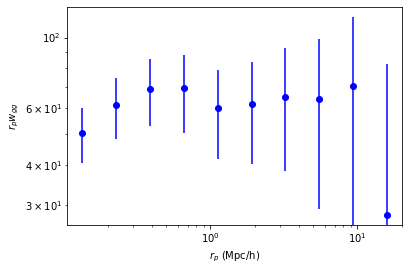

In [86]:
rp=w_jk['data0']['rp']
errorbar(rp,rp*w_jk['data0']['wgg'],rp*w_jk['data']['wgg_err'],fmt='bo')
loglog()
xlabel(r'$r_p$ (Mpc/h)')
ylabel(r'$r_p w_{gg}$')

Text(0, 0.5, '$r_p w_{g\\kappa}$')

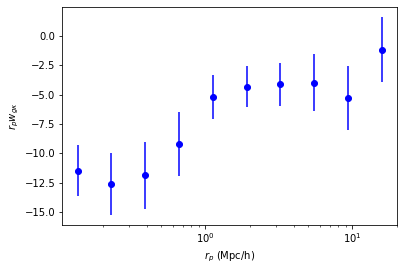

In [87]:
rp=w_jk['data0']['rp']
errorbar(rp,rp*w_jk['data0']['wgp'],rp*w_jk['data']['wgp_err'],fmt='bo')
#loglog()
xscale('log')
xlabel(r'$r_p$ (Mpc/h)')
ylabel(r'$r_p w_{g\kappa}$')

# Residual plots

In [88]:
residsuse = 'NNfullresids'

In [89]:
def calc_mean(xvar='',yvar='',data=[],data_cuts=None,rms=0,bins=None,N_bins=20,x_min=None,x_max=None,xlog=False,**kwargs):
    """
    Compute the mean of y in bins of x.
    
    Arguments
    ----------------
    xvar: name of the x variable column
    yvar: name of the y variable column
    data: Dataset, can be a dict, astropy or pandas table or numpy named array
    data_cuts: Any cuts to be applied on data. Boolean array. Useful for jackknife calculations
    rms: if non-zero, compute rms instead of mean. quantity returned is <y**(rms+1)>^{1./(rms+1)}. rms can be any number.
    bins: bin edges for the x axis to use. If None, we can compute it here using following arguments
    N_bins: Number of bins
    x_min: minimum value of x to use. If None, minimum from data[xvar] will be used
    x_max: maximum value of x to use. If None, maximum from data[xvar] will be used
    xlog: If True, use log bins in x. Otherwise linear bins are used.
    
    Returns:
    bins: bin edges
    bc: Bin centers
    mean_y: mean value of y within bins
    """
    datx=data[xvar]
    daty=data[yvar]
    if data_cuts is not None:
        datx=datx[data_cuts]
        daty=daty[data_cuts]
    if bins is None:
        if x_min is None:
            x_min=min(datx)
        if x_max is None:
            x_max=max(datx)
        if xlog:
            bins=np.logspace(np.log10(x_min),np.log10(x_max),N_bins+1)
        else:
            bins=np.linspace(x_min,x_max,N_bins+1)
    x_c,_=np.histogram(datx,bins=bins)
    x_c=np.float64(x_c)
    y_c,_=np.histogram(datx,weights=(daty**(rms+1.))/(rms+1),bins=bins)
    mean_y=y_c/x_c
    mean_y=mean_y**(1./(rms+1.))
    bc=0.5*(bins[1:]+bins[:-1])
    return bins,bc,mean_y

In [90]:
def calc_mean_jk(mean_func=calc_mean,jk_col='jk',njk=None,xvar='',yvar='',data=[],data_cuts=None,rms=0,bins=None,N_bins=20,x_min=None,x_max=None,xlog=False,**kwargs):
    """
    Compute the mean of y in bins of x, for every jackknife region. Returns a dict with calclations for all jackknife regions as well as the jackknife mean and covariance.
    Arguments
    ----------------
    mean_func=calc_mean: function to use for computing mean values. 
    jk_col: jackknife column name
    remaining arguments are same as calc_mean function above.
    
    returns:
    
    """
    if njk is None:
        njk=max(data[jk_col])+1
    njk=int(njk)
    jkr=np.arange(njk)
    means={}
    bins,bins_center,means['full']=mean_func(xvar=xvar,yvar=yvar,data=data,data_cuts=data_cuts,rms=rms,bins=bins,N_bins=N_bins,x_min=x_min,x_max=x_max,xlog=xlog,**kwargs)
    mean=np.zeros((njk,len(bins_center)))
    dat_jk=data[jk_col]
    for i in jkr:
        x=dat_jk!=i
        if data_cuts is not None:
            x=np.logical_and(x,data_cuts)
        bins,bins_center,mean[i]=mean_func(xvar=xvar,yvar=yvar,data=data,data_cuts=x,rms=rms,bins=bins,N_bins=N_bins,x_min=x_min,x_max=x_max,xlog=xlog,**kwargs)
    means['regions']=mean
    means['jk_mean']=np.mean(mean,axis=0)
    means['jk_var']=np.var(mean,axis=0)*(njk-1)*(njk-1)/njk
    means['jk_err']=np.sqrt(means['jk_var'])
    return bins,bins_center,means

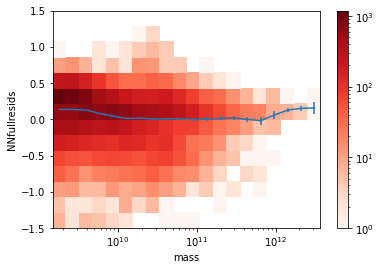

In [91]:
bins,bc,m=calc_mean_jk(jk_col='jk',data=S_dat,xvar='mass',yvar=residsuse,xlog=True)

_=hist2d(np.float64(S_dat['mass']),S_dat[residsuse],
  bins=[np.float64(bins),np.linspace(-1.5,1.5,15)],
  norm=LogNorm(),cmap='Reds')
errorbar(bc,m['jk_mean'],m['jk_err'])
xscale('log')
xlabel('mass')
ylabel(residsuse)
colorbar()
plt.show()

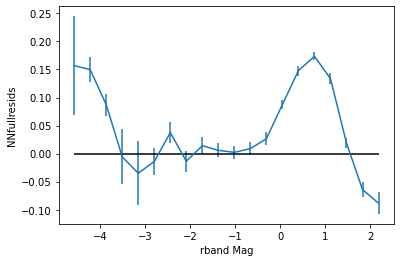

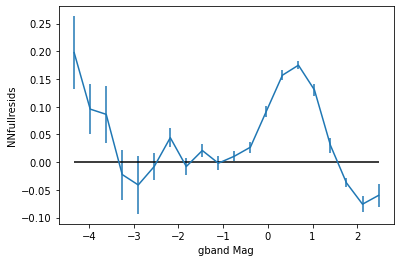

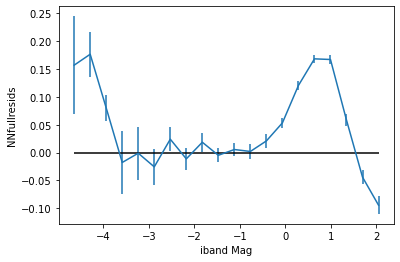

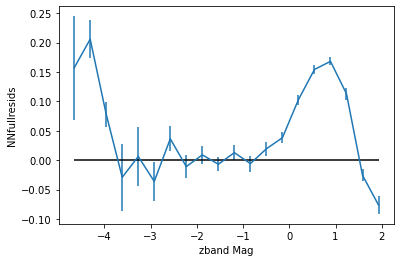

In [92]:
vlist = {'mc_disk','g - r','r - i','e1','e2','gband Mag'}
vlist = predsscl

for vname in vlist:
    bins,bc,m=calc_mean_jk(jk_col='jk',data=S_dat,xvar=vname,yvar=residsuse,xlog=False)

    #_=hist2d(np.float64(S_dat[vname]),S_dat['PPRresids'],
    #  bins=[np.float64(bins),np.linspace(-1.5,1.5,15)],
    #  norm=LogNorm(),cmap='Reds')
    errorbar(bc,m['jk_mean'],m['jk_err'])
    hlines(0,bc[0],bc[-1])
    xlabel(vname)
    ylabel(residsuse)
    #colorbar()
    plt.show()

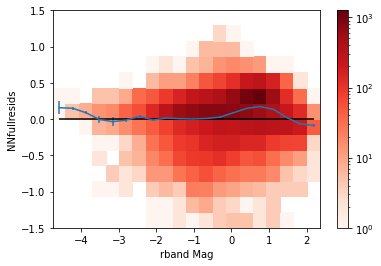

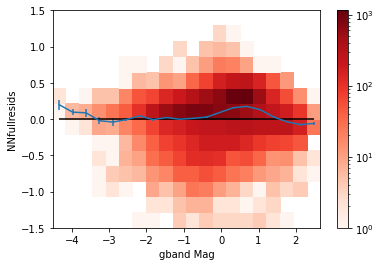

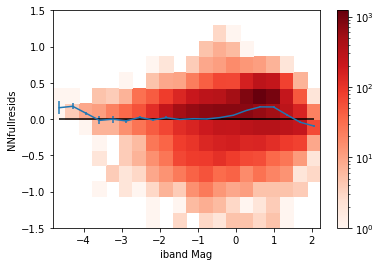

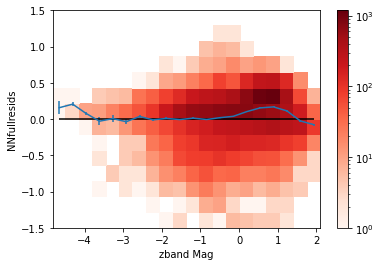

In [93]:
vlist = {'f_disk','g - r','r - i','e1','e2','gband Mag'}
vlist = predsscl

for vname in vlist:
    bins,bc,m=calc_mean_jk(jk_col='jk',data=S_dat,xvar=vname,yvar=residsuse,xlog=False)

    _=hist2d(np.float64(S_dat[vname]),S_dat[residsuse],
      bins=[np.float64(bins),np.linspace(-1.5,1.5,15)],
      norm=LogNorm(),cmap='Reds')
    errorbar(bc,m['jk_mean'],m['jk_err'])
    hlines(0,bc[0],bc[-1])
    xlabel(vname)
    ylabel(residsuse)
    colorbar()
    plt.show()

# RMSE

In [94]:
print("RMSE PPR on test set:")
print(sqrt(mean((PPRfitsontest-test_labels)**2)))

print("RMSE PPR on training set:")
print(sqrt(mean(residuals**2)))

RMSE PPR on test set:
0.2679702102999569
RMSE PPR on training set:
0.2593108382861657


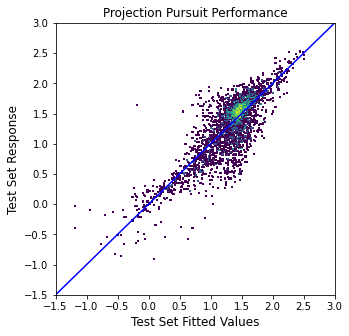

In [95]:
plt.figure(figsize=[5,5])
hist2d(x=PPRfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Projection Pursuit Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

In [96]:
print("RMSE NN on test set:")
print(sqrt(mean((NNfitsontest-test_labels)**2)))

print("RMSE NN on training set:")
print(sqrt(mean((NNfitsontrain-train_labels)**2)))

RMSE NN on test set:
0.3120203867679842
RMSE NN on training set:
0.3047150208197385


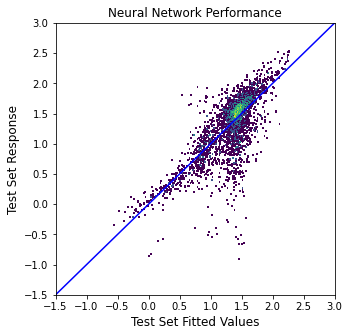

In [97]:
plt.figure(figsize=[5,5])
hist2d(x=NNfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Neural Network Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()


----------------------------------------------------
Output files stored in:
./temp/ChadAnalyses/Mags/

----------------------------------------------------
Predictors Used in Projection Pursuit Model:
['rband Mag', 'gband Mag', 'iband Mag', 'zband Mag']

----------------------------------------------------
Predictors Used in Neural Network Model:
['rband Mag', 'gband Mag', 'iband Mag', 'zband Mag']

----------------------------------------------------
Number of projection functions in PPR: 5

----------------------------------------------------
Seed used in train/test split: 1

----------------------------------------------------
RMSE PPR on test set: 0.268
RMSE PPR on training set: 0.259

----------------------------------------------------
Model: "SimpleNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   (None, 200)               1000      
______________________________

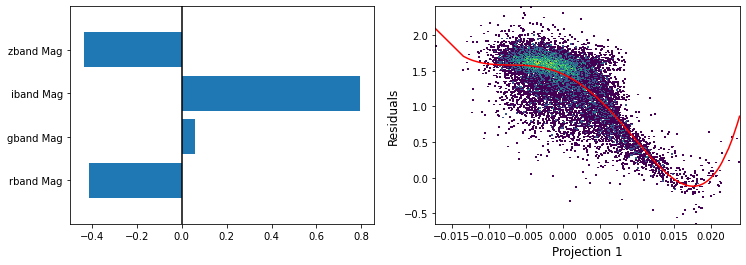

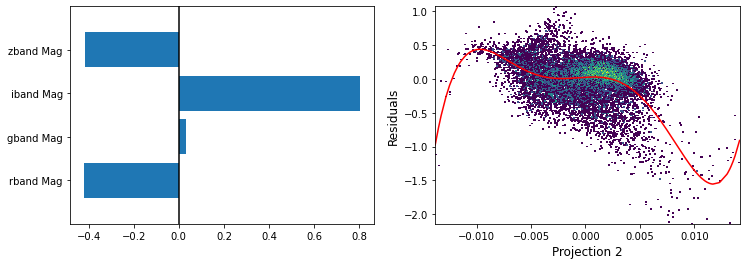

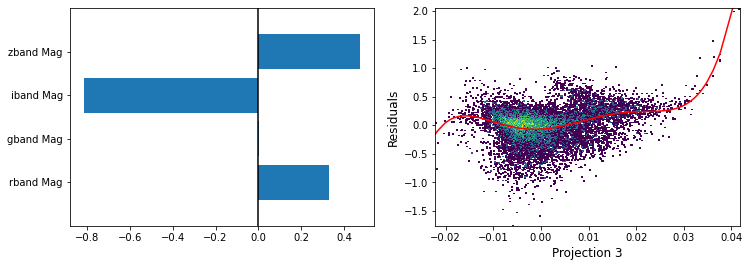

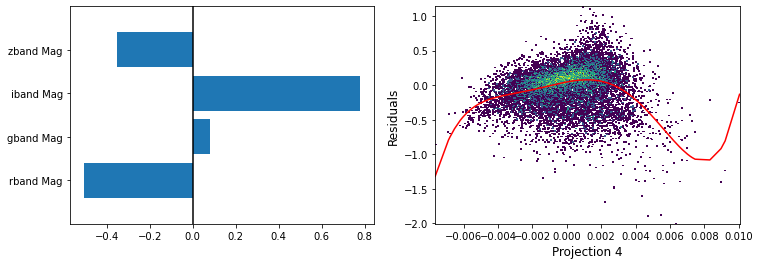

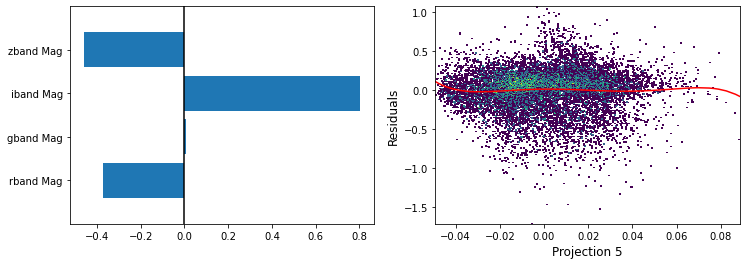

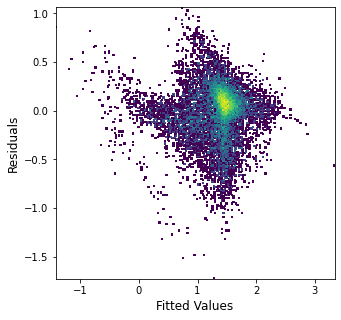

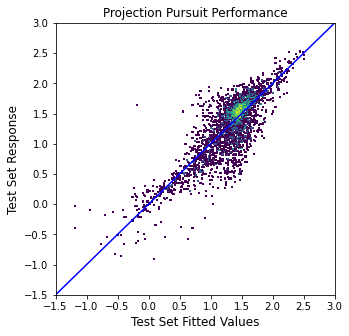

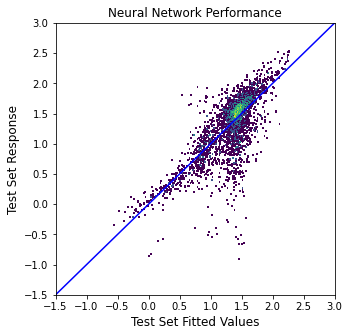

In [98]:
ReportOutput()